# Vinho Verde: Wine Quality Analysis

## Introduction

Wine is an alcoholic beverage made from the fermentation of grape juice, with many factors determining its quality. Wine without any acidity is “flat”, hence a fixed acidity level. Volatile acidity is the measure of acetic acid in wine, if it is above a threshold the wine will taste sour, citric acid enhances the flavour, residual sugar in wine is leftover sugar from grapes; higher sugar levels increase sweetness, and chloride contributes to saltiness in wine. 

**The main question we are answering is: What produces the highest quality of wine given our predictors, (VA, citric acidity, residual sugar, chloride, sulfur dioxide, and sulphate)?**

The dataset used is collected by Paulo Cortez, from the University of Minho in Portugal. He, along with A. Cerdeira, F. Almeida, T. Matos, and J. Reis, Viticulture Commission of the Vinho Verde Region(CVRVV), Porto, Portugal collected data about the Vinho Verde wines from Portugal. This dataset (from 2009) observes the physicochemical qualities of the wine (acidity, sulphates, etc.), and excludes grape type, wine brand, or other subjective qualities.

**Citation:**

P. Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009

## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 4)
set.seed(10000)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We use the `read_csv2()` function to read the file from the web.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_red <- read_csv2(url)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): volatile acidity, citric acid, chlorides, density, sulphates
dbl (2): total sulfur dioxide, quality

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We clean the column names to remove spaces using `make.names`, then change the datatypes of columns to dbl using `mutate()` and `as.double()` and finally remove the columns we dont wish to use using `select()`.

In [3]:
colnames(wine_red) <- make.names(colnames(wine_red))

wine_red <- wine_red |>
            mutate(across(fixed.acidity:sulphates, as.double), quality = as.factor(quality)) |>
            select(-total.sulfur.dioxide, -pH, -alcohol, -density)

wine_red

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.70,0,19,0.076,11,0.56,5
78,0.88,0,26,0.098,25,0.68,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,0.645,0.12,2,0.075,32,0.71,5
6,0.310,0.47,36,0.067,18,0.66,6


Splitting the dataset into training and testing sets.

In [4]:
wine_split <- initial_split(wine_red, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

wine_train

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.70,0.00,19,0.076,11,0.56,5
78,0.76,0.04,23,0.092,15,0.65,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
74,0.25,0.29,22,0.054,19,0.76,7
7,0.56,0.17,17,0.065,15,0.68,7


**1.**
Checking how many NA values are present in each column using the `apply()` function. 

In [5]:
apply(X = is.na(wine_train), MARGIN = 2, FUN = sum)

fixed.acidity    volatile.acidity         citric.acid      residual.sugar 
                  0                   0                   0                   0 
          chlorides free.sulfur.dioxide           sulphates             quality 
                  0                   0                   0                   0

Since there are no NA values in any of the columns, it is clear that all columns have 1197 rows of observations.

**2.**
Summarizing the means and ranges of all variables using `summarize()` and `map_df()`.

In [6]:
# mean_summary <- summarize(wine_train, across(fixed.acidity:sulphates, mean))
mean_summary <- wine_train |>
                select(-quality) |>
                map_df(mean)

range_summary <- summarize(wine_train, across(fixed.acidity:sulphates, range))

mean_summary
range_summary

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
74.72705,0.5282805,0.2690234,26.11853,0.08737145,16.4424,0.656803


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,0.12,0,2,0.012,1,0.33
159,1.33,1,655,0.611,375,2.00


The range data gives us the minimum and maximum values for each column in the database.

**3.**
Finding out means of predictors that correspond to each level in the quality scale. This will help us later to check if our prediction of wine quality makes logical sense.

In [7]:
group_by(wine_train, quality) |>
        summarize(across(fixed.acidity:sulphates, mean))

quality,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,83.14286,0.7814286,0.1742857,25.57143,0.11300000,13.57143,0.5900000
4,72.09524,0.6832143,0.2026190,25.21429,0.09054762,12.69048,0.6078571
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,81.84459,0.4116216,0.3757432,37.26351,0.07411486,19.10811,0.7387838
8,72.80000,0.4390000,0.3350000,19.50000,0.06530000,13.00000,0.7640000


From this table, we can see that a quality 4 wine for example corresponds to an average value of 23.5 in residual sugar.

**4.**
Finding overall summary of dataset using `summary()`.

In [8]:
summary(wine_train)

 fixed.acidity    volatile.acidity  citric.acid    residual.sugar  
 Min.   :  5.00   Min.   :0.1200   Min.   :0.000   Min.   :  2.00  
 1st Qu.: 68.00   1st Qu.:0.4000   1st Qu.:0.090   1st Qu.: 17.00  
 Median : 77.00   Median :0.5200   Median :0.255   Median : 22.00  
 Mean   : 74.73   Mean   :0.5283   Mean   :0.269   Mean   : 26.12  
 3rd Qu.: 91.00   3rd Qu.:0.6400   3rd Qu.:0.420   3rd Qu.: 26.00  
 Max.   :159.00   Max.   :1.3300   Max.   :1.000   Max.   :655.00  
   chlorides       free.sulfur.dioxide   sulphates      quality
 Min.   :0.01200   Min.   :  1.00      Min.   :0.3300   3:  7  
 1st Qu.:0.07000   1st Qu.:  7.00      1st Qu.:0.5500   4: 42  
 Median :0.07900   Median : 14.00      Median :0.6200   5:512  
 Mean   :0.08737   Mean   : 16.44      Mean   :0.6568   6:479  
 3rd Qu.:0.09000   3rd Qu.: 21.00      3rd Qu.:0.7300   7:148  
 Max.   :0.61100   Max.   :375.00      Max.   :2.0000   8: 10  

## Visualization

We use the `ggplot` function to graph how each variable contributes to each quality. 
Then we used `plot_grid` function to group each graph together to help us better visualize and compare our data set. 

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


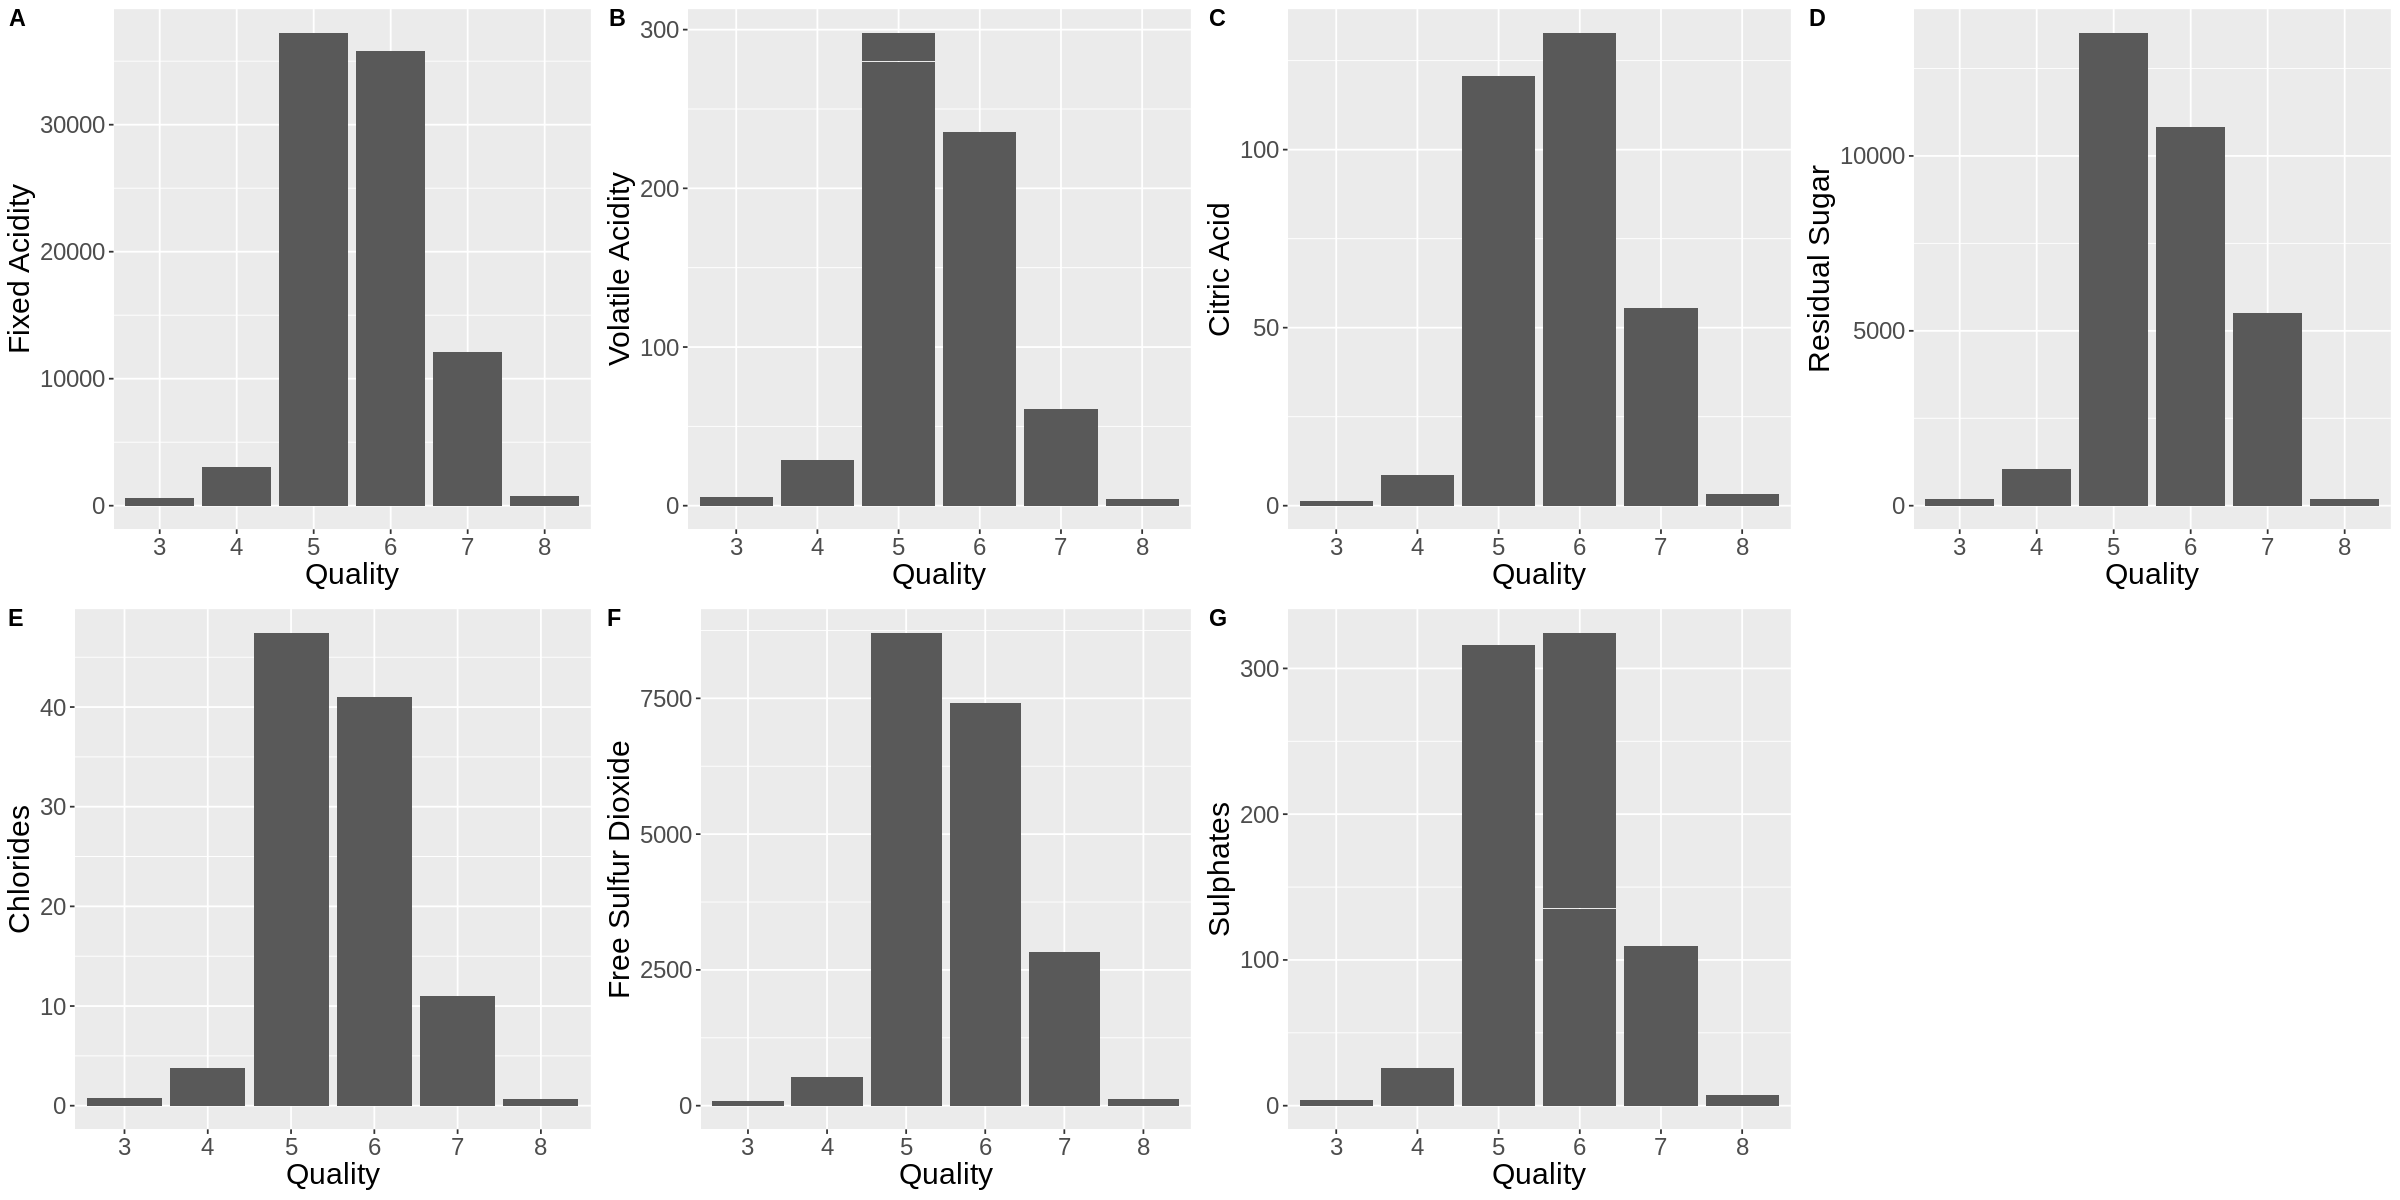

In [9]:
options(repr.plot.height = 10, repr.plot.width = 20)

fixed_acidity_plot <- ggplot(wine_train, aes(x = fixed.acidity, y = quality)) +
                geom_histogram(stat = "identity") +
                #facet_grid(rows = vars(quality))+
                labs(x = "Fixed Acidity", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

volatile_acidity_plot <- ggplot(wine_train, aes(x = volatile.acidity, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Volatile Acidity", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

citric_acid_plot <- ggplot(wine_train, aes(x = citric.acid, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Citric Acid", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()
 
residual_sugar_plot <- ggplot(wine_train, aes(x = residual.sugar, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Residual Sugar", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

chlorides_plot <- ggplot(wine_train, aes(x = chlorides, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Chlorides", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

free_sulfur_dioxide_plot <- ggplot(wine_train, aes(x = free.sulfur.dioxide, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Free Sulfur Dioxide", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

sulphates_plot <- ggplot(wine_train, aes(x = sulphates, y = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Sulphates", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

plot_grid(fixed_acidity_plot, volatile_acidity_plot, citric_acid_plot, residual_sugar_plot, chlorides_plot, free_sulfur_dioxide_plot, sulphates_plot,  
          labels = c("A", "B", "C", "D", "E", "F", "G"),
          ncol = 4, nrow = 2)

From reading these graphs, we can collect many useful information regarding to how each variables changes the overall quality of the wine. For example, the fixed acidity plot shows us that wines with quality of 3 contains amount ranging from 70 to 120, while wines with quality of 4 ranges from 0 to 125, and so on. 

## Method
We will create a scatterplot graph and assess how each variable changes the quality of wine, which has the biggest impact with the least change, then use classification to predict wine quality on a scale of 1-10. Columns with insignificant effect on the data (density, pH, alcohol, total sulfur dioxide) will be removed. Columns with significant impact (fixed acidity, volatile acidity, citric acid, residual sugar, sulfur dioxide, sulphates, and quality) will be kept. 
We will visualize the result to make another scatter plot graph. The y-axis will have the quality of the wine on a 1-10 scale and on the x-axis will have the other variable it is being compared to. This will provide several graphs visualizing each variable's impact on wine quality.

## Expected Outcomes and Significance
1. **What do we expect to find?**

We expect to determine the ideal ratio of wine factors to achieve the highest quality of vinho verde, and which variables are more consequential in comparison to others. There may be a “breaking point” within a variable, (a spot where the quality will drastically change after a certain threshold). 

2. **What impact could such findings have?**

Determining wine quality can promote wine testing and ensure safety within the food industry. It can inform consumers and motivate sellers to uphold a certain standard of quality. Furthermore, the quality of wine can serve as a reflection of its contents, which provides insight as to whether the wine is safe and follows food health and safety guidelines. 

3. **What future questions could this lead to?**

There may be further research into the factors not in this dataset, and whether certain variables can be compromised. It can also lead to further questions like “How do we cost effectively make high quality wine”, or wine producing the most sales, etc. 


## The K-Nearest-Neighbors Classification Model

**1.** We split the data using the `initial_split()` function shown above. 

**2.** We used the `vfold_cv()` function to split up the training data for cross validation. 

In [10]:
wine_vfold <- vfold_cv(wine_train, v = 10, strata = quality)

**3.** We passed in the training data set into the `recipe()` function to create a recipe that specifies the target variable `quality`, which is the one that we want to predict while the rest are used as predictors indicated with `.`.  

   The `step_center()` and `step_scale()` are both used to standardize, which will centre and scale all the variables in the dataset. Centering will make sure that every variable has an average of 0, while scaling will make sure that every variable has standard deviation of 1. 

In [11]:
wine_recipe <- recipe(quality ~ . , data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
wine_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          7

Operations:

Scaling for all_predictors()
Centering for all_predictors()

**4.** We created a K-Nearest-Neighbors model specification using the `nearest_neighbor()` function with the `tune()` function since we want to select the best value of K for this model. 

The `set_engine()` specifies which package or system will be used for training the model, which in this case, we use the “kknn” package to perform the K-nearest neighbours classification. 

The `set_mode` function specifies what type of problem we are dealing with, which in this case, this is a classification problem. 

In [12]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


**5.** We added the `recipe` and `model specification` to a `workflow()`, and used the `tune_grid()` function on the train/validation splits to estimate the classifer accuracy for a range of K values. 

In [13]:
knn_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples  = wine_vfold, grid = 10) |>
    collect_metrics() |> 
    filter(.metric == "accuracy")
knn_results

! Fold02: internal:
  No observations were detected in `truth` for level(s): '3', '8'
  Computation will proceed by ignoring those levels.

! Fold03: internal:
  No observations were detected in `truth` for level(s): '3', '8'
  Computation will proceed by ignoring those levels.

! Fold04: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.

! Fold07: internal:
  No observations were detected in `truth` for level(s): '3', '8'
  Computation will proceed by ignoring those levels.

! Fold08: internal:
  No observations were detected in `truth` for level(s): '3', '8'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.5900859,10,0.008578411,Preprocessor1_Model01
3,accuracy,multiclass,0.5425194,10,0.015527152,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,multiclass,0.5284281,10,0.01289799,Preprocessor1_Model09
15,accuracy,multiclass,0.5276299,10,0.01226684,Preprocessor1_Model10


**6.** We created an `accuracy_vs_k_plot` in order to help us choose the optimal k value. 

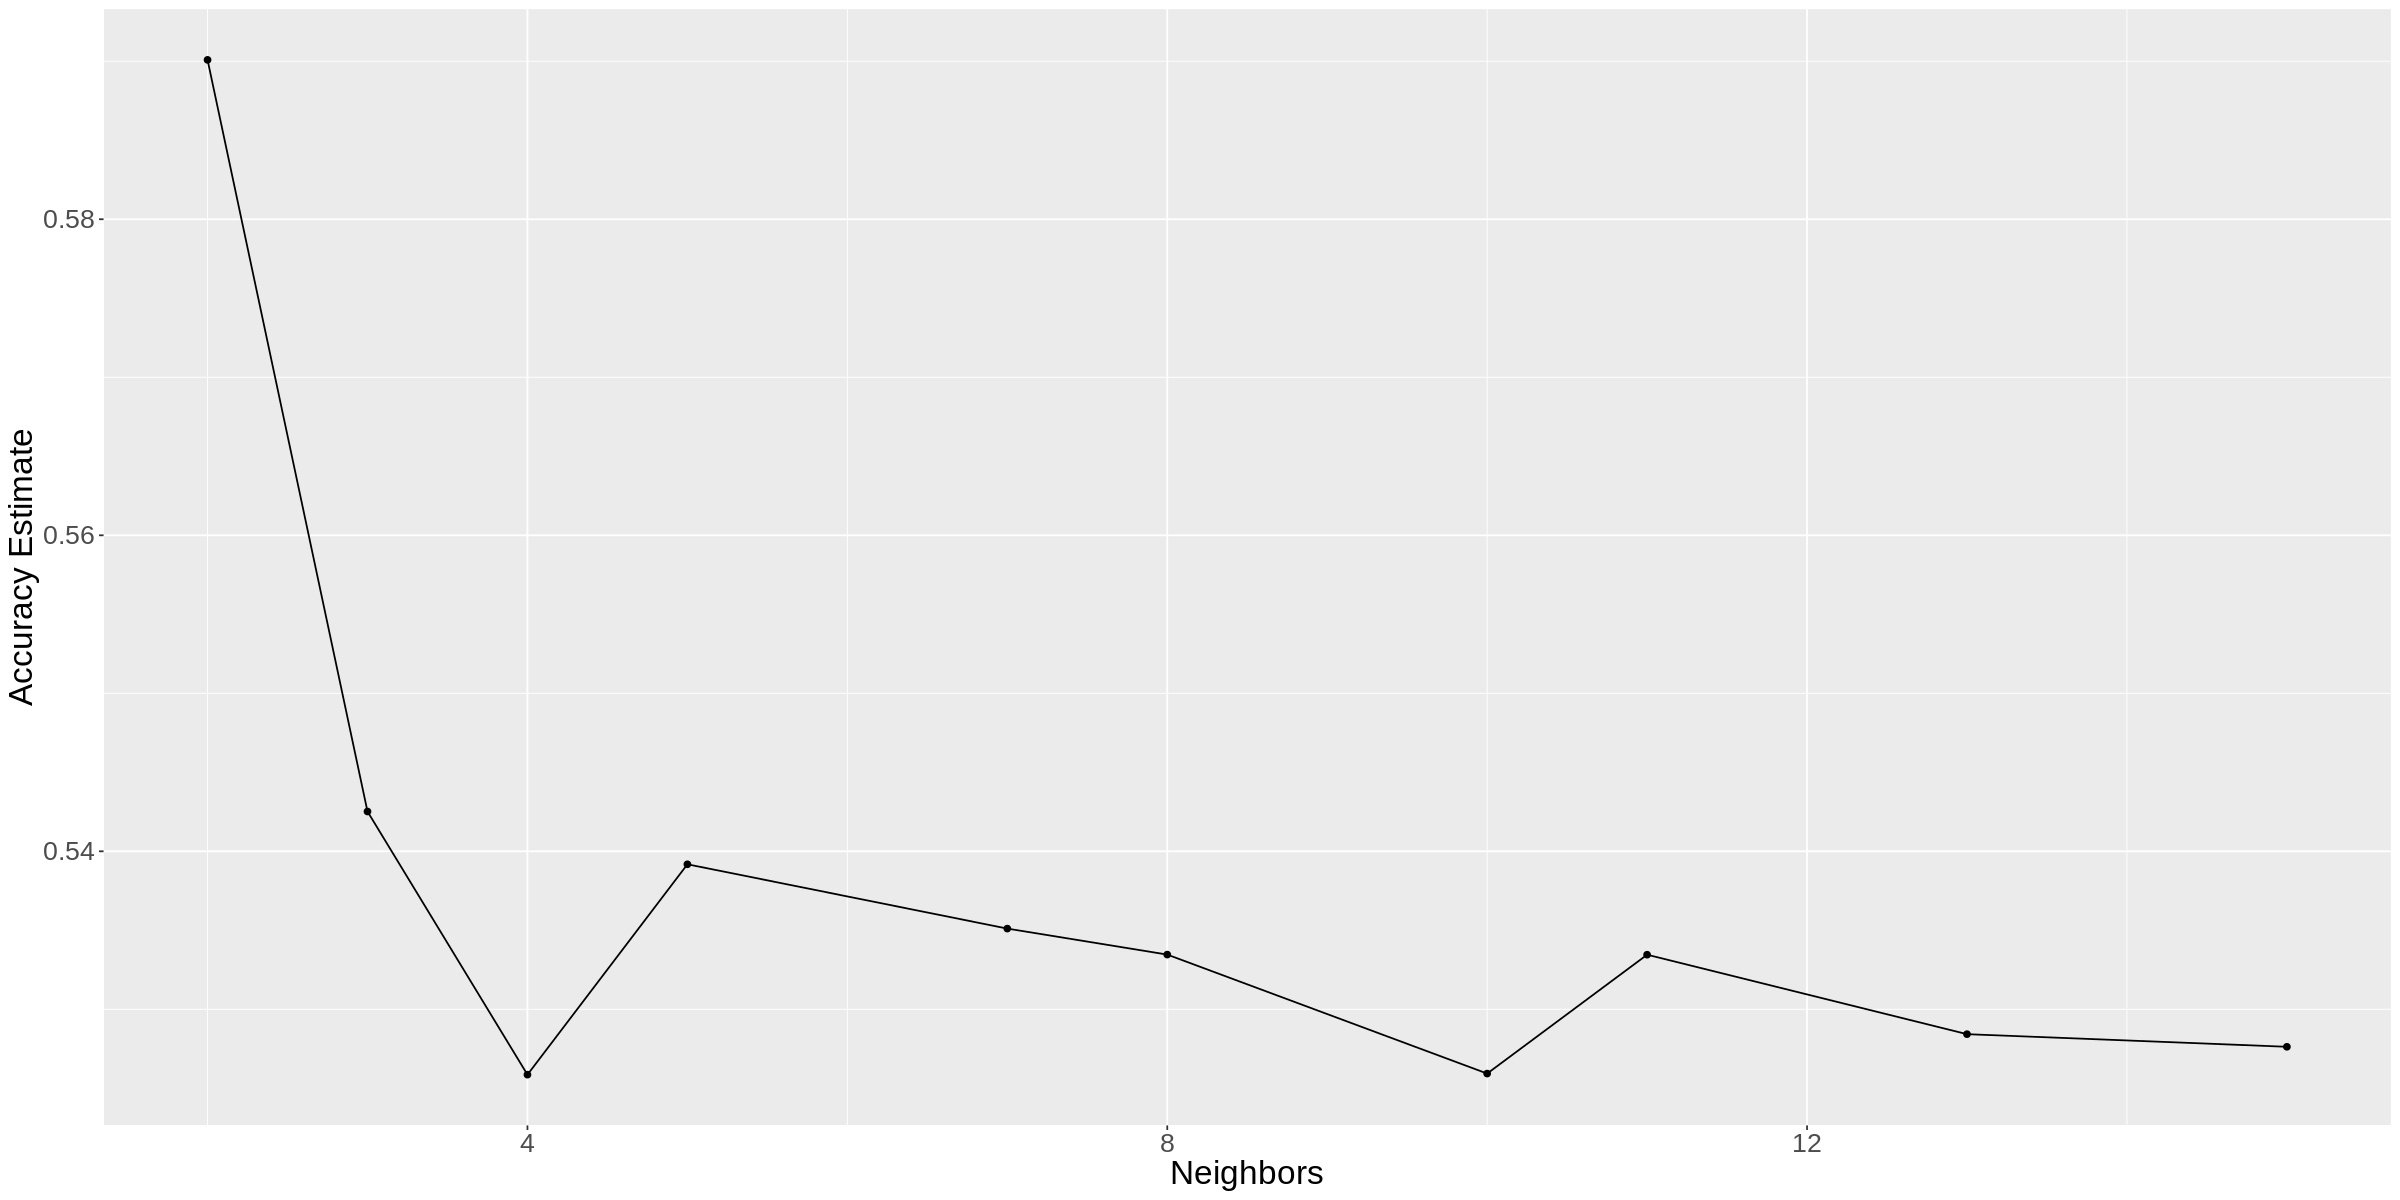

In [14]:
accuracy_vs_k_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
accuracy_vs_k_plot

**7.** Based on the plot above, We choosed K = 2 because that was where it obtain its best accuracy, which is roughly 59%. Then we made a new model specifcation based on K = 2, and re-trained the classifier using the `fit()` function. 

In [15]:
best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")
best_k_spec

best_fit <- workflow() |>
    add_recipe(wine_recipe) |> 
    add_model(best_k_spec) |> 
    fit(data = wine_train)
best_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 2
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4858097
Best kernel: rectangular
Best k: 2

**8.** Lastly, we got the prediction column and compared the accuracy of the predictions to the true values in the test set. Furthermore, we also compared the predictions to the true values in a confusion matrix. 

In [16]:
wine_test_predictions <- predict(best_fit, wine_test) |>
    bind_cols(wine_test)
wine_test_predictions

wine_test_predictions_accuracy <- wine_test_predictions |> 
    metrics(truth = quality, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
wine_test_predictions_accuracy

wine_confusion_mat <- wine_test_predictions |> 
    conf_mat(truth = quality, estimate = .pred_class)
wine_confusion_mat

.pred_class,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,sulphates,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,78,0.88,0.00,26,0.098,25,0.68,5
4,79,0.60,0.06,16,0.069,15,0.46,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,61,0.715,0.10,26,0.053,13,0.5,5
7,67,0.320,0.44,24,0.061,24,0.8,7


.metric,.estimate
<chr>,<dbl>
accuracy,0.605985


          Truth
Prediction   3   4   5   6   7   8
         3   0   0   0   3   0   0
         4   0   1   6   1   1   0
         5   2   7 117  42   6   2
         6   1   2  39  96  15   3
         7   0   1   6  16  29   3
         8   0   0   1   1   0   0

## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References

- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.

-we can cite creator of R + the creators of dataset